In [47]:
!pip install pyspark

In [48]:
from pyspark.sql import SparkSession
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

## Read The Data 

In [49]:
df = pd.read_csv('/kaggle/input/airfare-ml-predicting-flight-fares/Scraped_dataset.csv')

In [50]:
df.head()

,Date of Booking,Date of Journey,Airline-Class,Departure Time,Arrival Time,Duration,Total Stops,Price
0,15/01/2023,16/01/2023,SpiceJet \nSG-8169\nECONOMY,20:00\nDelhi,22:05\nMumbai,02h 05m,non-stop,"5,335"
1,15/01/2023,16/01/2023,Indigo \n6E-2519\nECONOMY,23:00\nDelhi,01:20\nMumbai,02h 20m,non-stop,"5,899"
2,15/01/2023,16/01/2023,GO FIRST \nG8- 354\nECONOMY,22:30\nDelhi,00:40\nMumbai,02h 10m,non-stop,"5,801"
3,15/01/2023,16/01/2023,SpiceJet \nSG-8709\nECONOMY,18:50\nDelhi,20:55\nMumbai,02h 05m,non-stop,"5,794"
4,15/01/2023,16/01/2023,Air India \nAI-805\nECONOMY,20:00\nDelhi,22:10\nMumbai,02h 10m,non-stop,"5,955"


## Data Preprocessing

In [51]:
# Convert the data to the form /d-/d/d-/d/d/d/d
df['Date of Booking'] = df['Date of Booking'].str.replace('/', '-')
df['Date of Journey'] = df['Date of Journey'].str.replace('/', '-')
df.head()

,Date of Booking,Date of Journey,Airline-Class,Departure Time,Arrival Time,Duration,Total Stops,Price
0,15-01-2023,16-01-2023,SpiceJet \nSG-8169\nECONOMY,20:00\nDelhi,22:05\nMumbai,02h 05m,non-stop,"5,335"
1,15-01-2023,16-01-2023,Indigo \n6E-2519\nECONOMY,23:00\nDelhi,01:20\nMumbai,02h 20m,non-stop,"5,899"
2,15-01-2023,16-01-2023,GO FIRST \nG8- 354\nECONOMY,22:30\nDelhi,00:40\nMumbai,02h 10m,non-stop,"5,801"
3,15-01-2023,16-01-2023,SpiceJet \nSG-8709\nECONOMY,18:50\nDelhi,20:55\nMumbai,02h 05m,non-stop,"5,794"
4,15-01-2023,16-01-2023,Air India \nAI-805\nECONOMY,20:00\nDelhi,22:10\nMumbai,02h 10m,non-stop,"5,955"


In [52]:
# Define a lambda function to convert the day value to a day name
def convert_day_to_name(date):
    day_name = date.strftime('%A')
    return day_name

In [53]:
# Extract Journey Day from the Date of Journey
df['Journey_Day'] = pd.to_datetime(df['Date of Journey'], format='%d-%m-%Y').apply(convert_day_to_name).astype('category')

# 
df['Total Stops'] = df['Total Stops'].str.split('\n').str[0]

#Extract Airline 
df['Airline'] = df['Airline-Class'].str.split('\s\n').str[0]

#Extract Flight Code 
df['Flight_code'] = df['Airline-Class'].str.split('\n').str[1]

#Extract Flight Class 
df['Class'] = df['Airline-Class'].str.split('\n').str[2]

#Extract Source
df['Source'] = df['Departure Time'].str.split('\n').str[1]

#Extract Destination
df['Destination'] = df['Arrival Time'].str.split('\n').str[1]
df.head()

,Date of Booking,Date of Journey,Airline-Class,Departure Time,Arrival Time,Duration,Total Stops,Price,Journey_Day,Airline,Flight_code,Class,Source,Destination
0,15-01-2023,16-01-2023,SpiceJet \nSG-8169\nECONOMY,20:00\nDelhi,22:05\nMumbai,02h 05m,non-stop,"5,335",Monday,SpiceJet,SG-8169,ECONOMY,Delhi,Mumbai
1,15-01-2023,16-01-2023,Indigo \n6E-2519\nECONOMY,23:00\nDelhi,01:20\nMumbai,02h 20m,non-stop,"5,899",Monday,Indigo,6E-2519,ECONOMY,Delhi,Mumbai
2,15-01-2023,16-01-2023,GO FIRST \nG8- 354\nECONOMY,22:30\nDelhi,00:40\nMumbai,02h 10m,non-stop,"5,801",Monday,GO FIRST,G8- 354,ECONOMY,Delhi,Mumbai
3,15-01-2023,16-01-2023,SpiceJet \nSG-8709\nECONOMY,18:50\nDelhi,20:55\nMumbai,02h 05m,non-stop,"5,794",Monday,SpiceJet,SG-8709,ECONOMY,Delhi,Mumbai
4,15-01-2023,16-01-2023,Air India \nAI-805\nECONOMY,20:00\nDelhi,22:10\nMumbai,02h 10m,non-stop,"5,955",Monday,Air India,AI-805,ECONOMY,Delhi,Mumbai


In [ ]:
# Map Departure Time to categories
def map_time_to_category(time_str):
    hour = pd.to_datetime(time_str).hour
    if hour < 6:
        return 'Before 6 AM'
    elif hour >= 6 and hour < 12:
        return '6 AM - 12 PM'
    elif hour >= 12 and hour < 18:
        return '12 PM - 6 PM'
    elif hour >= 18:
        return 'After 6 PM'
    else:
        return 'Other'

# Apply the lambda function to the 'Time' column and store the result in a new column
df['Departure'] = df['Departure Time'].str.split('\n').str[0].apply(map_time_to_category)

# Apply the lambda function to the 'Time' column and store the result in a new column
df['Arrival'] = df['Arrival Time'].str.split('\n').str[0].apply(map_time_to_category)

In [ ]:
def convert_time_to_decimal(time_str):
    time_parts = time_str.split('h ')
    hours = int(time_parts[0])
    minutes = int(time_parts[1].replace('m', ''))
    decimal_time = hours + (minutes / 60)
    return decimal_time

# Apply the lambda function to the 'Time' column and store the result in a new column
df['Duration'] = df['Duration'].apply(convert_time_to_decimal)

In [ ]:
# Renaming and remove , from the price value
df['Fare'] = df['Price'].str.replace(',', '').astype(float)


In [ ]:
# Convert the date columns to datetime format
df['Date of Booking'] = pd.to_datetime(df['Date of Booking'])
df['Date of Journey'] = pd.to_datetime(df['Date of Journey'])

# Calculate the days left between the 'Booking Date' and 'Journey Date' columns
df['Days_left'] = (df['Date of Journey'] - df['Date of Booking']).dt.days


In [ ]:
df = df.drop('Airline-Class', axis=1)
df = df.drop('Departure Time', axis=1)
df = df.drop('Arrival Time', axis=1)
df = df.drop('Price', axis=1)
df.head(13)

In [ ]:
# display summary statistics of numerical columns
df.describe()

In [ ]:
# get corelation with numerical columns
df.corr().T

In [ ]:
# get numbers of null values 
df.isnull().sum()

In [ ]:
# get number of dublicate records
print("number of dublicate records:",df.duplicated().sum())
print("precentage of dublicate records:" ,(df.duplicated().sum()/df.shape[0])*100,"%")

In [ ]:
# remove dublicate records
print("shape before remove dublicates:",df.shape)
# Dropping all the duplicates and keeping the last entry only.
df.drop_duplicates(keep='last',ignore_index=True ,inplace=True)
print("shape after remove dublicates:",df.shape)

In [ ]:
# get colums for month and day
df['Day'] = df['Date of Journey'].dt.day
df['Month'] = df['Date of Journey'].dt.month
months = {
    1:"January",
    2:"Febuary",
    3:"March",
    4:"April",
    5:"May",   
    6:"June",
    7:"July",
    8:"August",
    9:"September",
    10:"October",
    11:"November",
    12:"December"
}
df['Month'] = df['Month'].map(months)

df.head(20)

## Data Visualization

In [ ]:
import matplotlib.pyplot as plt
figure, axis = plt.subplots(figsize=(7,7))
class_counts = df["Class"].value_counts()
plt.pie(class_counts, labels=class_counts.index, autopct='%.2f')
plt.title("Class")
plt.show()
print(class_counts)

In [ ]:
figure, axis = plt.subplots(1, 2,figsize=(20,10))

class_counts = df["Departure"].value_counts()
axis[0].pie(class_counts, labels=class_counts.index, autopct='%.2f')
axis[0].set_title("Departure")

class_counts = df["Arrival"].value_counts()
axis[1].pie(class_counts, labels=class_counts.index, autopct='%.2f')
axis[1].set_title("Arrival")

plt.show()

**Most flights has Departure and Arrival time between 6AM - 12PM**

In [ ]:
figure, axis = plt.subplots(figsize=(7,7))
class_counts = df["Month"].value_counts()
plt.pie(class_counts, labels=class_counts.index, autopct='%.2f')
plt.title("Month")
plt.show()

**Most flights in Febuary**

In [ ]:
figure, axis = plt.subplots(figsize=(9,9))
class_counts = df["Total Stops"].value_counts()
plt.pie(class_counts, labels=class_counts.index, autopct='%.2f')
plt.title("Total Stops")
plt.show()

**Most of flights has one stop**

In [ ]:
# Lets first find the number of flights flying from and to each airport
sns.set(style='darkgrid')
fig,axs = plt.subplots(1,2, figsize=(20,10),sharey=True)
sns.countplot(data=df,y="Source",ax=axs[0])
sns.countplot(data=df,y="Destination",ax=axs[1])
for ax in axs:
    ax.set_xlabel('Number of Flight Tickets')
axs[0].set_title("Number of Flights flying from",size=15)
axs[1].set_title("Number of Flights flying to",size=15)
plt.show()

In [ ]:
# Count the number of flights for each source-destination pair
flight_count = df.groupby(['Source', 'Destination']).size().reset_index(name='Count')

# Sort the data by count
flight_count = flight_count.sort_values(by='Count')

# Plot a bar chart of the flight count by source-destination pairs
fig = plt.figure(figsize=(12, 6))
plt.bar(flight_count['Source'] + '-' + flight_count['Destination'], flight_count['Count'])
plt.xticks(rotation=90)
plt.xlabel('Source-Destination pair')
plt.ylabel('Number of flights')
plt.show()

**The highest number of flights are between Delhi-Mumbai and Delhi-Bangalore**

In [ ]:
# Group the data by Arrival and calculate the mean Fare
arrival_fares = df.groupby('Journey_Day')['Journey_Day'].count().sort_values()

# Plot the bar chart
plt.bar(arrival_fares.index, arrival_fares.values)
plt.xticks(rotation=45)
plt.xlabel('Journey_day')
plt.ylabel('Number of flights')
plt.show()

**All days has almost the same number of flights**

In [ ]:
plt.figure(figsize=(25,10))
sns.histplot(x=df.Airline,hue=df.Class)
plt.ylabel("Frequency of flights for each category",size=15)
plt.title("Frequency of flights by each category",size=15)
plt.show()

- Vistara is the only airline that has Premium Economy class

- Air India is the only airline that has first class

- Vistara and Air India are the only airline that has Business class

- all airlines has Economy class

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(df['Duration'], bins=20)
plt.xlabel('Flight Duration (hours)')
plt.ylabel('Frequency')
plt.title('Histogram of Flight Duration')
plt.show()

The minimum duration of a flight is 0.75 hours, indicating that there are some very short flights in the dataset. The maximum duration of a flight is 43.58 hours and most of the flights has less than 20 hour

## Extracting insights from data

#### Average Fare Vs Days for each category

In [ ]:
# Coverting the categorical into a numeric form using Label Encoder
    
plt.figure(figsize=(25,10))
sns.barplot(x=df.Journey_Day,y=df.Fare,hue=df.Class,palette="Greens_r",order=['Saturday','Sunday','Monday','Tuesday','Wednesday','Thursday','Friday'])
plt.ylabel("Average Flight Fare by day for each category",size=15)
plt.title("Average Flight fare for every day by each category",size=15)
plt.show()

changing the day not affect average price of the flights exept for first category

#### Average Fare Vs Days Left

In [ ]:
# Group the data by Days_left and calculate the mean Fare
daily_fares = df.groupby('Days_left')['Fare'].mean()

# Plot the time series
plt.plot(daily_fares.index, daily_fares.values)
plt.xlabel('Days left')
plt.ylabel('Fare')
plt.show()

There is a slight decrease in fares as the number of days left to the journey decreases. The fare is highest when there is only one day left for the journey, and it decreases gradually as the days left increase. However, this trend is not linear, and there are some fluctuations in the fare values for certain days left.

#### Average Fare Vs Days for each category

In [ ]:
# Coverting the categorical into a numeric form using Label Encoder
df['Duration']=df['Duration'].astype(float)

plt.figure(figsize=(20,10))
sns.lineplot(data=df, x = "Duration", y ="Fare",hue="Class")
plt.title("Cost per minute in INR for non-stop flights")
plt.show()

There is a increase in fares as the duration in hour increase for first class. but in other clasess there is high fluctuations in the fare values but not great sign of increase

#### Average Fare Vs Arrival time

In [ ]:
# Group the data by Arrival and calculate the mean Fare
arrival_fares = df.groupby('Arrival')['Fare'].mean().sort_values()

# Plot the bar chart
plt.bar(arrival_fares.index, arrival_fares.values)
plt.xticks(rotation=45)
plt.xlabel('Arrival')
plt.ylabel('Fare')
plt.show()

It can be concluded that flight prices vary depending on the arrival time of the flights. The highest fares are observed for flights arriving in the evening (after 6 PM),while the cheapest fares are observed for flights arriving before 6 AM

#### Average Fare Vs Departure time

In [ ]:
# Group the data by Departure and calculate the mean Fare
arrival_fares = df.groupby('Departure')['Fare'].mean().sort_values()

# Plot the bar chart
plt.bar(arrival_fares.index, arrival_fares.values)
plt.xticks(rotation=45)
plt.xlabel('Departure')
plt.ylabel('Fare')
plt.show()

It can be concluded that flight prices vary depending on the Departure time of the flights. The highest fares are observed for flights departure in the evening (after 6 PM),while the cheapest fares are observed for flights departure before 6 AM

#### Average Fare Vs Airline

In [ ]:
# Group the data by Arrival and calculate the mean Fare
airline_fares = df.groupby('Airline')['Fare'].mean().sort_values()

# Plot the bar chart
plt.bar(airline_fares.index, airline_fares.values)
plt.xticks(rotation=45)
plt.xlabel('Airline')
plt.ylabel('Averag Fare')
plt.show()



the graph show that Airline (Air India & Vistara) has the highest average Price whilw AkasaAir has the cheapest price 

#### Average Fare Vs Airline for each Classes

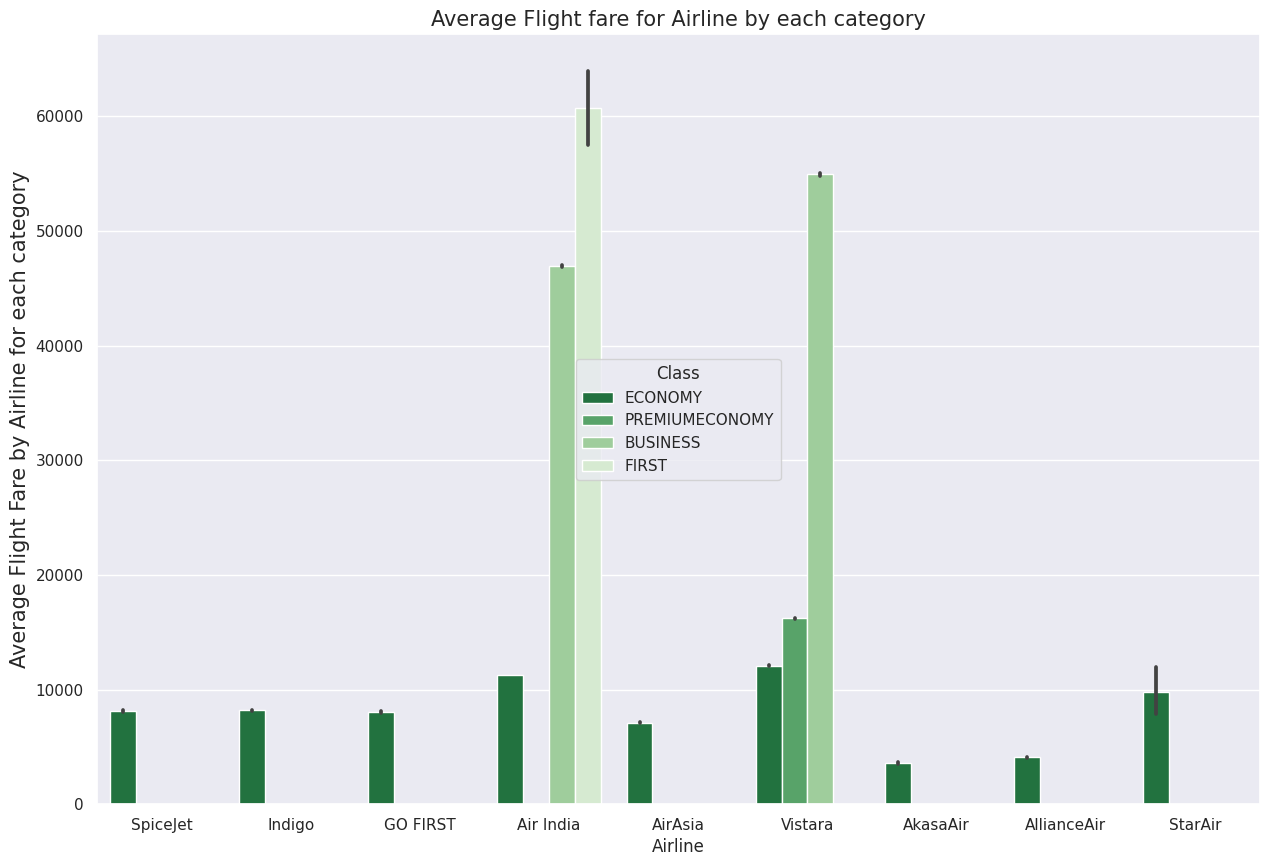

In [80]:
plt.figure(figsize=(15,10))
sns.barplot(x=df.Airline,y=df.Fare,hue=df.Class,palette="Greens_r")
plt.ylabel("Average Flight Fare by Airline for each category",size=15)
plt.title("Average Flight fare for Airline by each category",size=15)
plt.show()

Reason for Air India get the heghiest average price because it has first and business classes and Vistara has Pre Economy which are with high price and for economy flight they have slightly higher price and AkasaAir has the lower price 

#### Average Fare Vs Total stops 

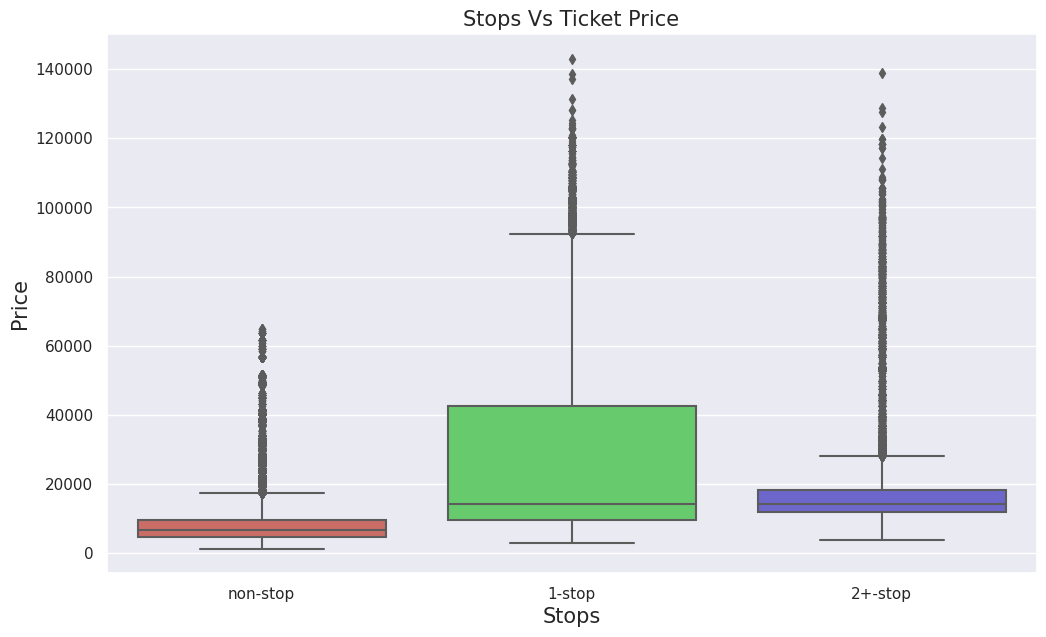

In [81]:
plt.figure(figsize=(12,7))
sns.boxplot(x='Total Stops',y='Fare',data=df,palette='hls')
plt.title('Stops Vs Ticket Price',fontsize=15)
plt.xlabel('Stops',fontsize=15)
plt.ylabel('Price',fontsize=15)
plt.show()

Flights with 1-stop has the highest mean price and variance and non-stop has the cheapest price but lower variance
this result not make sense as non-stop flight expected to have more price than 1-stop and 2+-stop 

#### Average Fare Vs  Source & Destination

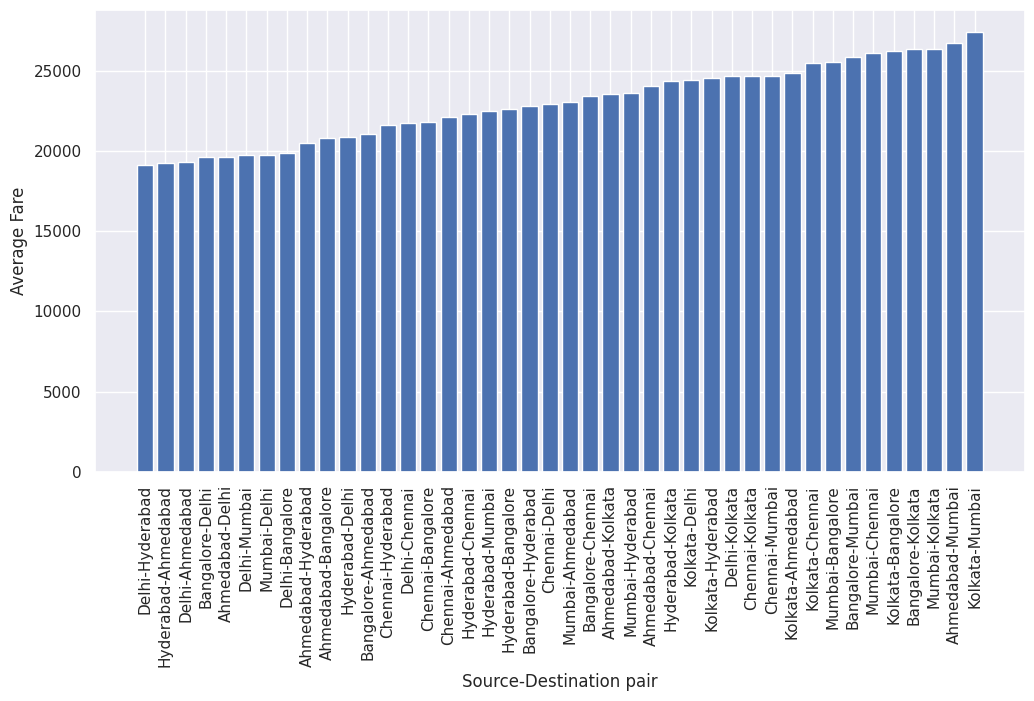

In [82]:
# Calculate the mean fare for each source-destination pair
mean_fare = df.groupby(['Source', 'Destination'])['Fare'].mean().reset_index(name='Mean Fare')

# Sort the data by mean fare
mean_fare = mean_fare.sort_values(by='Mean Fare')

# Plot a bar chart of the mean fare by source-destination pairs
fig = plt.figure(figsize=(12, 6))
plt.bar(mean_fare['Source'] + '-' + mean_fare['Destination'], mean_fare['Mean Fare'])
plt.xticks(rotation=90)
plt.xlabel('Source-Destination pair')
plt.ylabel('Average Fare')
plt.show()

The route with the highest average fare is Kolkata-Mumbai with an average fare of Rs26997.85. The route with the lowest average fare is Hyderabad-Ahmedabad with an average fare of Rs19001.85.

In [83]:
# get corelation with numerical columns
df.corr()

/tmp/ipykernel_34/2674856925.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,Duration,Fare,Days_left,Day
Duration,1.000000,0.193277,-0.009442,0.015665
Fare,0.193277,1.000000,-0.029889,0.031282
Days_left,-0.009442,-0.029889,1.000000,-0.580479
Day,0.015665,0.031282,-0.580479,1.000000


/tmp/ipykernel_34/1254472323.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  p = df.corr(method='pearson')


Text(0.5, 1.0, 'Pearson Correlation')

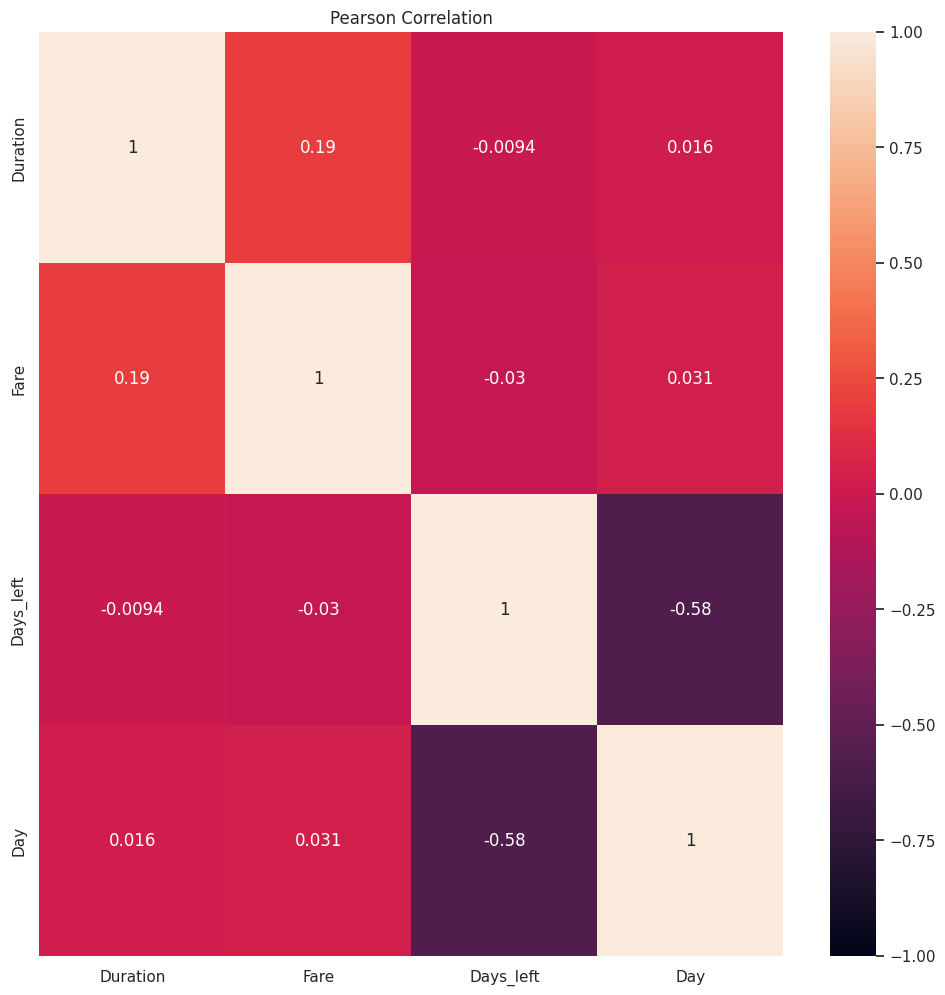

In [84]:
p = df.corr(method='pearson')
plt.figure(figsize=(12,12))
heatmap = sns.heatmap(p, vmin=-1, vmax=1, annot=True)
plt.title("Pearson Correlation")

In [85]:
# Coverting the labels into a numeric form using Label Encoder
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
for col in df.columns:
    if df[col].dtype=='object':
        df[col]=le.fit_transform(df[col])
        
df.head()

,Date of Booking,Date of Journey,Duration,Total Stops,Journey_Day,Airline,Flight_code,Class,Source,Destination,Departure,Arrival,Fare,Days_left,Day,Month
0,2023-01-15,2023-01-16,2.083333,2,Monday,6,1214,1,3,6,2,2,5335.0,1,16,4
1,2023-01-15,2023-01-16,2.333333,2,Monday,5,356,1,3,6,2,3,5899.0,1,16,4
2,2023-01-15,2023-01-16,2.166667,2,Monday,4,929,1,3,6,2,3,5801.0,1,16,4
3,2023-01-15,2023-01-16,2.083333,2,Monday,6,1228,1,3,6,2,2,5794.0,1,16,4
4,2023-01-15,2023-01-16,2.166667,2,Monday,0,852,1,3,6,2,2,5955.0,1,16,4


## Model/Classifier training

In [86]:
# drop colums with very low corelations
df=df.drop(columns=['Date of Booking','Date of Journey','Journey_Day'])
df.head()

,Duration,Total Stops,Airline,Flight_code,Class,Source,Destination,Departure,Arrival,Fare,Days_left,Day,Month
0,2.083333,2,6,1214,1,3,6,2,2,5335.0,1,16,4
1,2.333333,2,5,356,1,3,6,2,3,5899.0,1,16,4
2,2.166667,2,4,929,1,3,6,2,3,5801.0,1,16,4
3,2.083333,2,6,1228,1,3,6,2,2,5794.0,1,16,4
4,2.166667,2,0,852,1,3,6,2,2,5955.0,1,16,4


In [87]:
from sklearn.model_selection import train_test_split

# Define the predictor and target variables
X = df.drop('Fare', axis=1)
y = df['Fare']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30,random_state=42)

#Scaling the values to convert the int values to Machine Languages
from sklearn.preprocessing import MinMaxScaler
mmscaler=MinMaxScaler(feature_range=(0,1))
X_train=mmscaler.fit_transform(X_train)
X_test=mmscaler.fit_transform(X_test)
X_train=pd.DataFrame(X_train)
X_test=pd.DataFrame(X_test) 



### KNN 
- with k = 1

In [113]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

k = 1
knn = KNeighborsRegressor(n_neighbors=k)
pipeline = Pipeline([('knn', knn)])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
# Evaluate the performance of the model using R-squared
r2 = r2_score(y_test, y_pred)
print("R-squared score:", r2)

# Evaluate the model using root mean squared error
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("Root Mean Squared Error:", rmse)

R-squared score: 0.882797708636361
Root Mean Squared Error: 6998.663054381801


#### on training data

In [114]:
# Predict the fares for the train set
y_pred_train = pipeline.predict(X_train)

# Evaluate the performance of the model using R-squared
r2_train = r2_score(y_train, y_pred_train)
print("R-squared score:", r2_train)

# Evaluate the model using root mean squared error
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
print("Root Mean Squared Error:", rmse_train)

R-squared score: 0.9996640587450347
Root Mean Squared Error: 373.4125714721834


### Linear Regression

In [89]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score,mean_squared_error
# Create a linear regression model and fit the data
model = LinearRegression()
model.fit(X_train, y_train)

# Predict the fares for the test set
y_pred = model.predict(X_test)

# Evaluate the performance of the model using R-squared
r2 = r2_score(y_test, y_pred)
print("R-squared score:", r2)

# Evaluate the model using root mean squared error
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("Root Mean Squared Error:", rmse)

R-squared score: 0.4520834173630537
Root Mean Squared Error: 15132.276083465254


#### Predict on training data


In [90]:
# Predict the fares for the train set
y_pred_train = model.predict(X_train)

# Evaluate the performance of the model using R-squared
r2_train = r2_score(y_train, y_pred_train)
print("R-squared score:", r2_train)

# Evaluate the model using root mean squared error
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
print("Root Mean Squared Error:", rmse_train)

R-squared score: 0.4509515602023658
Root Mean Squared Error: 15096.02463103469


#### Random Forest

In [91]:
# Create a Random Forest regression model and fit the data
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Predict the fares for the test set
y_pred = model.predict(X_test)

# Evaluate the performance of the model using R-squared
r2 = r2_score(y_test, y_pred)
print("R-squared score:", r2)

# Evaluate the model using root mean squared error
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("Root Mean Squared Error:", rmse)

R-squared score: 0.9581656601522637
Root Mean Squared Error: 4181.320850334988


#### Predict on training data

In [92]:
# Predict the fares for the train set
y_pred_train = model.predict(X_train)

# Evaluate the performance of the model using R-squared
r2_train = r2_score(y_train, y_pred_train)
print("R-squared score:", r2_train)

# Evaluate the model using root mean squared error
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
print("Root Mean Squared Error:", rmse_train)

R-squared score: 0.9947214643499598
Root Mean Squared Error: 1480.1781684438236


### Pyspark Models

In [93]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import RandomForestRegressor

spark = SparkSession.builder.appName("crew_prediction").getOrCreate()

assembler = VectorAssembler(
    inputCols=['Airline', 'Flight_code', 'Class', 'Source', 'Departure', 'Total Stops',
       'Arrival', 'Destination', 'Duration', 'Days_left',
       'Month', 'Day'],
    outputCol="features"
)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/05/17 11:46:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [94]:
# Convert pandas DataFrame to Spark DataFrame
sdf = spark.createDataFrame(df)

In [95]:
print("Number of partitions before repartitioning:", sdf.rdd.getNumPartitions())
sdf = sdf.repartition(100)
print("Number of partitions before repartitioning:", sdf.rdd.getNumPartitions())

Number of partitions before repartitioning: 4


23/05/17 11:47:14 WARN TaskSetManager: Stage 0 contains a task of very large size (4778 KiB). The maximum recommended task size is 1000 KiB.


Number of partitions before repartitioning: 100


In [96]:
flight_df = assembler.transform(sdf)
flight_df = flight_df.select(['features', 'Fare'])
flight_df.show(3)

23/05/17 11:47:20 WARN TaskSetManager: Stage 1 contains a task of very large size (4778 KiB). The maximum recommended task size is 1000 KiB.


+--------------------+-------+
|            features|   Fare|
+--------------------+-------+
|[8.0,1363.0,3.0,3...|19613.0|
|[1.0,1023.0,1.0,3...|10180.0|
|[0.0,797.0,0.0,3....|42457.0|
+--------------------+-------+
only showing top 3 rows



In [97]:
results=[]
results_train=[]
train_data, test_data = flight_df.randomSplit([0.7, 0.3], seed=42)

### Linear Regression

In [98]:
import pyspark.ml.regression
lr = pyspark.ml.regression.LinearRegression(labelCol="Fare",featuresCol = 'features',maxIter=10, regParam=0.3, elasticNetParam=0.8)
model = lr.fit(train_data)
print("Coefficients: " + str(model.coefficients))
print("Intercept: " + str(model.intercept))

23/05/17 11:47:23 WARN TaskSetManager: Stage 4 contains a task of very large size (4778 KiB). The maximum recommended task size is 1000 KiB.
23/05/17 11:47:26 WARN TaskSetManager: Stage 5 contains a task of very large size (4778 KiB). The maximum recommended task size is 1000 KiB.
23/05/17 11:47:29 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/05/17 11:47:38 WARN TaskSetManager: Stage 9 contains a task of very large size (4778 KiB). The maximum recommended task size is 1000 KiB.


Coefficients: [435.96300454353366,15.737610483857715,-12924.445769619704,389.3421899009075,-390.0139100585012,-4253.549103853237,-116.56495945930902,477.0493333287054,272.6597141847681,-7.7405775357838955,204.31607925696983,52.146273698240265]
Intercept: 12607.759938108768


In [99]:
res = model.evaluate(test_data)
print(f"""
Linear Regression Results Report
==================================
RMSE:\t {res.rootMeanSquaredError}
MSE:\t {res.meanSquaredError}
R2:\t {res.r2}
Adj R2:\t{res.r2adj}
==================================
"""
)

results.append([res.rootMeanSquaredError,res.r2])

23/05/17 11:47:45 WARN TaskSetManager: Stage 13 contains a task of very large size (4778 KiB). The maximum recommended task size is 1000 KiB.



Linear Regression Results Report
RMSE:	 15110.782143141794
MSE:	 228335736.97749293
R2:	 0.4526769241712951
Adj R2:	0.45262778585189045



In [100]:
res = model.evaluate(train_data)
print(f"""
Linear Regression Results Report on train data
==================================
RMSE:\t {res.rootMeanSquaredError}
MSE:\t {res.meanSquaredError}
R2:\t {res.r2}
Adj R2:\t{res.r2adj}
==================================
"""
)

results_train.append([res.rootMeanSquaredError,res.r2])

23/05/17 11:47:50 WARN TaskSetManager: Stage 17 contains a task of very large size (4778 KiB). The maximum recommended task size is 1000 KiB.



Linear Regression Results Report on train data
RMSE:	 15105.22665751479
MSE:	 228167872.37489542
R2:	 0.4507005063854682
Adj R2:	0.4506793577231477



### Random Forest

In [101]:
# create a RandomForestRegressor model
rf = pyspark.ml.regression.RandomForestRegressor(labelCol="Fare",featuresCol = 'features',numTrees=10, maxDepth=5, seed=42)

# train the model on the training data
model = rf.fit(train_data)


23/05/17 11:47:54 WARN TaskSetManager: Stage 21 contains a task of very large size (4778 KiB). The maximum recommended task size is 1000 KiB.


In [102]:
from pyspark.ml.evaluation import RegressionEvaluator
# make predictions on the test data
predictions = model.transform(test_data)

# evaluate the performance of the model
evaluator = RegressionEvaluator(labelCol="Fare", metricName="rmse")
rmse = evaluator.evaluate(predictions)

print("RMSE:", rmse)

# compute R2
evaluator = RegressionEvaluator(labelCol="Fare", metricName="r2")
r2 = evaluator.evaluate(predictions)
print("R2:", r2)

results.append([rmse,r2])

23/05/17 11:48:19 WARN TaskSetManager: Stage 44 contains a task of very large size (4778 KiB). The maximum recommended task size is 1000 KiB.
23/05/17 11:48:23 WARN TaskSetManager: Stage 48 contains a task of very large size (4778 KiB). The maximum recommended task size is 1000 KiB.


RMSE: 7872.615216562265


R2: 0.8514379371978683


#### Evaluate on Train Data

In [103]:
# make predictions on the test data
predictions = model.transform(train_data)

# evaluate the performance of the model
evaluator = RegressionEvaluator(labelCol="Fare", metricName="rmse")
rmse = evaluator.evaluate(predictions)

print("RMSE:", rmse)

# compute R2
evaluator = RegressionEvaluator(labelCol="Fare", metricName="r2")
r2 = evaluator.evaluate(predictions)
print("R2:", r2)

results_train.append([rmse,r2])

23/05/17 11:48:26 WARN TaskSetManager: Stage 52 contains a task of very large size (4778 KiB). The maximum recommended task size is 1000 KiB.
23/05/17 11:48:30 WARN TaskSetManager: Stage 56 contains a task of very large size (4778 KiB). The maximum recommended task size is 1000 KiB.


RMSE: 7842.583576838111


R2: 0.8519279745287596


### GBTRegressor

In [104]:
from pyspark.ml.regression import GBTRegressor
gbt = GBTRegressor(labelCol="Fare",featuresCol = 'features', maxIter=10)
gbt_model = gbt.fit(train_data)


23/05/17 11:48:34 WARN TaskSetManager: Stage 60 contains a task of very large size (4778 KiB). The maximum recommended task size is 1000 KiB.
23/05/17 11:48:36 WARN TaskSetManager: Stage 61 contains a task of very large size (4778 KiB). The maximum recommended task size is 1000 KiB.


In [105]:
gbt_predictions = gbt_model.transform(test_data)
gbt_evaluator = RegressionEvaluator(labelCol="Fare", metricName="rmse")

rmse = gbt_evaluator.evaluate(gbt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

# compute R2
evaluator = RegressionEvaluator(labelCol="Fare", metricName="r2")
r2 = evaluator.evaluate(predictions)
print("R2:", r2)

results.append([rmse,r2])

23/05/17 11:49:41 WARN TaskSetManager: Stage 219 contains a task of very large size (4778 KiB). The maximum recommended task size is 1000 KiB.
23/05/17 11:49:45 WARN TaskSetManager: Stage 223 contains a task of very large size (4778 KiB). The maximum recommended task size is 1000 KiB.


Root Mean Squared Error (RMSE) on test data = 6609.68


R2: 0.8519279745287596


In [106]:
gbt_predictions = gbt_model.transform(train_data)
gbt_evaluator = RegressionEvaluator(labelCol="Fare", metricName="rmse")

rmse = gbt_evaluator.evaluate(gbt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

# compute R2
evaluator = RegressionEvaluator(labelCol="Fare", metricName="r2")
r2 = evaluator.evaluate(predictions)
print("R2:", r2)

results_train.append([rmse,r2])

23/05/17 11:49:49 WARN TaskSetManager: Stage 227 contains a task of very large size (4778 KiB). The maximum recommended task size is 1000 KiB.
23/05/17 11:49:53 WARN TaskSetManager: Stage 231 contains a task of very large size (4778 KiB). The maximum recommended task size is 1000 KiB.


Root Mean Squared Error (RMSE) on test data = 6566.41


R2: 0.8519279745287596


### Decision Tree Regressor

In [107]:
from pyspark.ml.regression import DecisionTreeRegressor
dt = DecisionTreeRegressor(labelCol="Fare",featuresCol = 'features')
dt_model = dt.fit(train_data)

23/05/17 11:49:57 WARN TaskSetManager: Stage 235 contains a task of very large size (4778 KiB). The maximum recommended task size is 1000 KiB.


In [108]:
dt_predictions = dt_model.transform(test_data)
dt_evaluator = RegressionEvaluator(labelCol="Fare", metricName="rmse")
rmse = dt_evaluator.evaluate(dt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)
dt_evaluator = RegressionEvaluator(labelCol="Fare", metricName="r2")
r2 = dt_evaluator.evaluate(dt_predictions)
print("R2 = %g" % r2)

results.append([rmse,r2])

23/05/17 11:50:07 WARN TaskSetManager: Stage 258 contains a task of very large size (4778 KiB). The maximum recommended task size is 1000 KiB.


Root Mean Squared Error (RMSE) on test data = 7219.18


23/05/17 11:50:12 WARN TaskSetManager: Stage 262 contains a task of very large size (4778 KiB). The maximum recommended task size is 1000 KiB.


R2 = 0.875076


In [109]:
dt_predictions = dt_model.transform(train_data)
dt_evaluator = RegressionEvaluator(labelCol="Fare", metricName="rmse")
rmse = dt_evaluator.evaluate(dt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)
dt_evaluator = RegressionEvaluator(labelCol="Fare", metricName="r2")
r2 = dt_evaluator.evaluate(dt_predictions)
print("R2 = %g" % r2)

results_train.append([rmse,r2])

23/05/17 11:50:15 WARN TaskSetManager: Stage 266 contains a task of very large size (4778 KiB). The maximum recommended task size is 1000 KiB.
23/05/17 11:50:19 WARN TaskSetManager: Stage 270 contains a task of very large size (4778 KiB). The maximum recommended task size is 1000 KiB.


Root Mean Squared Error (RMSE) on test data = 7183.88


R2 = 0.875757


In [110]:
print(results)

[[15110.782143141794, 0.4526769241712951], [7872.615216562265, 0.8514379371978683], [6609.6797587936235, 0.8519279745287596], [7219.175736199177, 0.8750762253245893]]


In [111]:
models=['LinearRegression','RandomForestRegressor','GBTRegressor','DecisionTreeRegressor']
result=pd.DataFrame({'Model_Name':models})
rmse = [val[0] for val in results]
result['Root Mean Squared Error (RMSE)']=rmse
r2 = [val[1] for val in results]
result['R2_score']=r2
result=result.sort_values(by='R2_score',ascending=False).reset_index(drop=True)
result

,Model_Name,Root Mean Squared Error (RMSE),R2_score
0,DecisionTreeRegressor,7219.175736,0.875076
1,GBTRegressor,6609.679759,0.851928
2,RandomForestRegressor,7872.615217,0.851438
3,LinearRegression,15110.782143,0.452677


### On Train Data

In [112]:
models=['LinearRegression','RandomForestRegressor','GBTRegressor','DecisionTreeRegressor']
result=pd.DataFrame({'Model_Name':models})
rmse = [val[0] for val in results_train]
result['Root Mean Squared Error (RMSE)']=rmse
r2 = [val[1] for val in results_train]
result['R2_score']=r2
result=result.sort_values(by='R2_score',ascending=False).reset_index(drop=True)
result

,Model_Name,Root Mean Squared Error (RMSE),R2_score
0,DecisionTreeRegressor,7183.877170,0.875757
1,RandomForestRegressor,7842.583577,0.851928
2,GBTRegressor,6566.414130,0.851928
3,LinearRegression,15105.226658,0.450701
